In [ ]:

import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class KBPDataset(Dataset):
    def __init__(self, patient_dir, augment=False):
        self.patient_paths = []
        
        if os.path.exists(patient_dir):
            self.patient_paths = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir) 
                                  if os.path.isdir(os.path.join(patient_dir, f))]
        
    def __len__(self):
        return len(self.patient_paths)
    
    def load_volume(self, path, is_ct=False):
        """ Robust CSV loader with automatic scaling """
        if not os.path.exists(path): return np.zeros((128,128,128), dtype=np.float32)
        
        try:
            
            df = pd.read_csv(path, header=None, usecols=[0])
            if not str(df.iloc[0,0]).replace('.','').isdigit():
                 df = pd.read_csv(path, header=0, usecols=[0])
            
            indices = df.iloc[:, 0].values.astype(int)
            
            
            if "PTV" in path or "Mask" in path:
                
                values = np.ones(len(indices), dtype=np.float32)
            else:
                
                try:
                    df_vals = pd.read_csv(path, header=None)
                    
                    raw = df_vals.iloc[:, 1].values
                    if not str(raw[0]).replace('.','').replace('-','').isdigit():
                        values = raw[1:].astype(np.float32)
                    else:
                        values = raw.astype(np.float32)
                except:
                    values = np.ones(len(indices), dtype=np.float32)

            
            if is_ct:
                
                if np.mean(values) > 0: 
                    values = values - 1000.0
                
                
                values = np.clip(values, -1000, 1000)
                
                
                values = (values - -1000) / 2000.0

            elif "dose" in path.lower():
                
                values = values / 80.0


            vol = np.zeros(128*128*128, dtype=np.float32)
            valid = (indices >= 0) & (indices < len(vol))
            vol[indices[valid]] = values[valid]
            
            return vol.reshape(128,128,128)
            
        except Exception as e:
            
            return np.zeros((128,128,128), dtype=np.float32)

    def __getitem__(self, idx):
        path = self.patient_paths[idx]
        
        
        ct = self.load_volume(os.path.join(path, "ct.csv"), is_ct=True)
        dose = self.load_volume(os.path.join(path, "dose.csv"), is_ct=False)
        
        
        ptv = self.load_volume(os.path.join(path, "PTV70.csv"))
        if np.sum(ptv) == 0: ptv = self.load_volume(os.path.join(path, "PTV63.csv"))
        if np.sum(ptv) == 0: ptv = self.load_volume(os.path.join(path, "PTV56.csv"))
        
       
        
        inp = np.stack([ct, ptv], axis=0) 
        out = dose[np.newaxis, ...]       
        
        return torch.from_numpy(inp).float(), torch.from_numpy(out).float()

✅ Found pt_201 at index 0


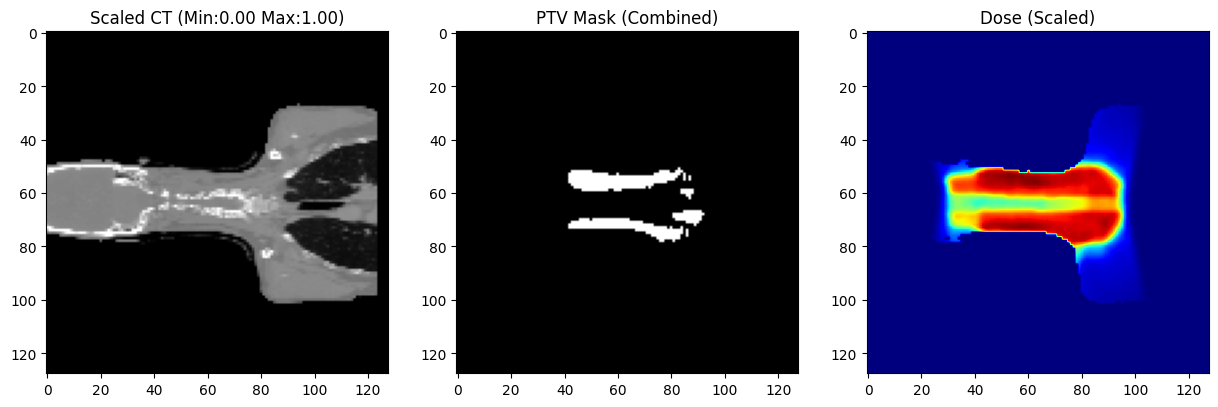

In [ ]:

import matplotlib.pyplot as plt

VAL_DIR = r"C:\Users\sajid\OneDrive\Desktop\KBP Dataset\archive\provided-data\validation-pats"
dataset = KBPDataset(VAL_DIR)


for i, p in enumerate(dataset.patient_paths):
    if "pt_201" in p:
        print(f" Found pt_201 at index {i}")
        inp, true_dose = dataset[i]
        
        
        ct_slice = inp[0, 64, :, :].numpy()
        ptv_slice = inp[1, 64, :, :].numpy()
        dose_slice = true_dose[0, 64, :, :].numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(ct_slice, cmap='gray')
        ax[0].set_title(f"Scaled CT (Min:{ct_slice.min():.2f} Max:{ct_slice.max():.2f})")
    
        
        ax[1].imshow(ptv_slice, cmap='gray')
        ax[1].set_title("PTV Mask (Combined)")
        
        ax[2].imshow(dose_slice, cmap='jet')
        ax[2].set_title("Dose (Scaled)")
        
        plt.show()
        break

In [ ]:

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split


DATA_DIR = r"C:\Users\sajid\OneDrive\Desktop\KBP Dataset\archive\provided-data\validation-pats"
MODEL_SAVE_PATH = r"C:\Users\sajid\OneDrive\Desktop\Morpho Dose Project\models\best_model_new.pth"
DEVICE = "cpu"
BATCH_SIZE = 2
EPOCHS = 20 

print(f"🚀 Setup: Looking for data in {DATA_DIR}...")


class KBPDataset(Dataset):
    def __init__(self, patient_paths):
        self.patient_paths = patient_paths
        
    def __len__(self):
        return len(self.patient_paths)
    
    def load_volume(self, path, is_ct=False):
        if not os.path.exists(path): return np.zeros((128,128,128), dtype=np.float32)
        try:
            
            df = pd.read_csv(path, header=None, usecols=[0])
            if not str(df.iloc[0,0]).replace('.','').isdigit():
                 df = pd.read_csv(path, header=0, usecols=[0])
            
            indices = df.iloc[:, 0].values.astype(int)
            
            
            if "PTV" in path or "Mask" in path:
                values = np.ones(len(indices), dtype=np.float32)
            else:
                try:
                    df_vals = pd.read_csv(path, header=None)
                    raw = df_vals.iloc[:, 1].values
                    
                    if not str(raw[0]).replace('.','').replace('-','').isdigit():
                        values = raw[1:].astype(np.float32)
                    else:
                        values = raw.astype(np.float32)
                except:
                    values = np.ones(len(indices), dtype=np.float32)

    
            if is_ct:
                
                if np.mean(values) > 0: values = values - 1000.0
                values = np.clip(values, -1000, 1000)
                values = (values - -1000) / 2000.0 
            elif "dose" in path.lower():
                values = values / 80.0


            vol = np.zeros(128*128*128, dtype=np.float32)
            valid = (indices >= 0) & (indices < len(vol))
            vol[indices[valid]] = values[valid]
            return vol.reshape(128,128,128)
        except:
            return np.zeros((128,128,128), dtype=np.float32)

    def __getitem__(self, idx):
        path = self.patient_paths[idx]
        
        
        ct = self.load_volume(os.path.join(path, "ct.csv"), is_ct=True)
        
        ptv = self.load_volume(os.path.join(path, "PTV70.csv"))
        if np.sum(ptv) == 0: ptv = self.load_volume(os.path.join(path, "PTV63.csv"))
        if np.sum(ptv) == 0: ptv = self.load_volume(os.path.join(path, "PTV56.csv"))
        
        
        dose = self.load_volume(os.path.join(path, "dose.csv"), is_ct=False)
        
        
        inp = np.stack([ct, ptv], axis=0) 
        out = dose[np.newaxis, ...]      
        
        return torch.from_numpy(inp).float(), torch.from_numpy(out).float()


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class UNet3D_2Channel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dconv_down1 = DoubleConv(2, 16) 
        self.dconv_down2 = DoubleConv(16, 32)
        self.dconv_down3 = DoubleConv(32, 64)
        self.maxpool = nn.MaxPool3d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        self.dconv_up2 = DoubleConv(32 + 64, 32)
        self.dconv_up1 = DoubleConv(16 + 32, 16)
        self.conv_last = nn.Conv3d(16, 1, kernel_size=1)
        self.relu = nn.ReLU() 

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.upsample(conv3)
        x = torch.cat([x, conv2], dim=1) 
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1) 
        x = self.dconv_up1(x)
        return self.relu(self.conv_last(x))


all_folders = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) 
               if os.path.isdir(os.path.join(DATA_DIR, f))]

if len(all_folders) == 0:
    print(" ERROR: No patient folders found! Check your path.")
else:
    
    train_size = int(0.8 * len(all_folders))
    val_size = len(all_folders) - train_size
    train_paths, val_paths = random_split(all_folders, [train_size, val_size])
    
    print(f" Data Found: {len(all_folders)} patients.")
    print(f"   Training on: {len(train_paths)}")
    print(f"   Validating on: {len(val_paths)}")

    train_ds = KBPDataset(train_paths)
    val_ds = KBPDataset(val_paths)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

    
    model = UNet3D_2Channel().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    print("\n Starting Training Loop...")
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        start = time.time()
        
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(".", end="") 
            
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        print(f"\nEpoch [{epoch+1}/{EPOCHS}] Train: {avg_train:.6f} | Val: {avg_val:.6f}")
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("   💾 Checkpoint Saved!")

    print("✅ Done! Model saved to:", MODEL_SAVE_PATH)

🚀 Setup: Looking for data in C:\Users\sajid\OneDrive\Desktop\KBP Dataset\archive\provided-data\validation-pats...
✅ Data Found: 40 patients.
   Training on: 32
   Validating on: 8

🚀 Starting Training Loop...
..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [1/20] Train: 0.014641 | Val: 0.012190
   💾 Checkpoint Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [2/20] Train: 0.006504 | Val: 0.010146
   💾 Checkpoint Saved!
..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [3/20] Train: 0.004999 | Val: 0.005694
   💾 Checkpoint Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [4/20] Train: 0.004437 | Val: 0.005489
   💾 Checkpoint Saved!
..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [5/20] Train: 0.004858 | Val: 0.008313
.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [6/20] Train: 0.004185 | Val: 0.003724
   💾 Checkpoint Saved!
.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [7/20] Train: 0.004035 | Val: 0.004114
.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [8/20] Train: 0.003768 | Val: 0.004037


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [9/20] Train: 0.003733 | Val: 0.003885


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [10/20] Train: 0.003553 | Val: 0.003552
   💾 Checkpoint Saved!
.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [11/20] Train: 0.003353 | Val: 0.003414
   💾 Checkpoint Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [12/20] Train: 0.003340 | Val: 0.003888
.....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [13/20] Train: 0.003335 | Val: 0.003712
...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [14/20] Train: 0.003062 | Val: 0.003548


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [15/20] Train: 0.003207 | Val: 0.003617
..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [16/20] Train: 0.003145 | Val: 0.003494
.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


...

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [17/20] Train: 0.003074 | Val: 0.003556


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


......

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [18/20] Train: 0.003072 | Val: 0.003449


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [19/20] Train: 0.003056 | Val: 0.004639
.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


..

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


.....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


....

C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)



Epoch [20/20] Train: 0.002942 | Val: 0.003311
   💾 Checkpoint Saved!
✅ Done! Model saved to: C:\Users\sajid\OneDrive\Desktop\Morpho Dose Project\models\best_model_new.pth


🚀 Starting Validation of NEW 2-Channel Model...
✅ New Model Loaded Successfully!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\611433865.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_locati

Patient 1: MAE=1.31 Gy | D95 Err=14.32 Gy


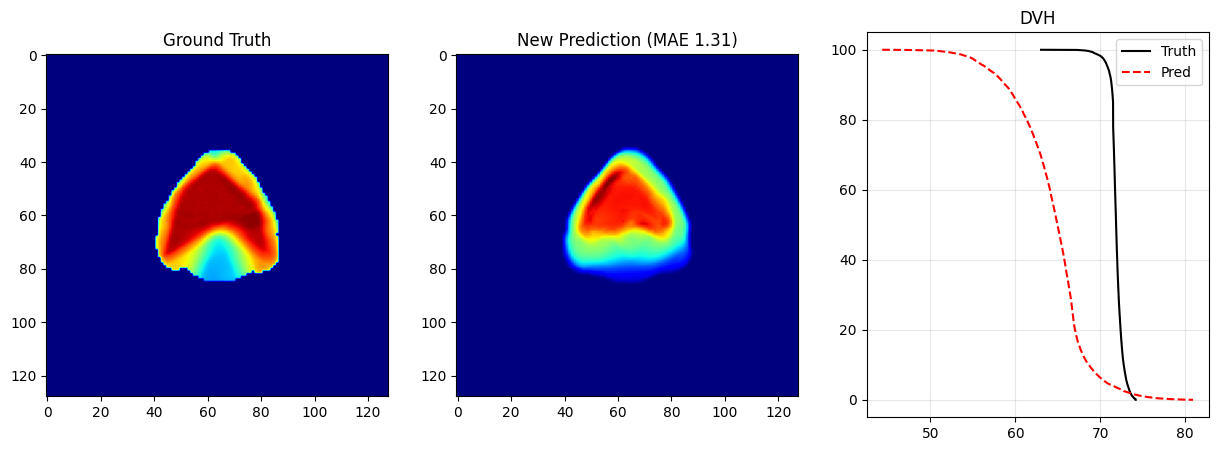

Patient 2: MAE=0.27 Gy | D95 Err=22.67 Gy
Patient 3: MAE=0.86 Gy | D95 Err=60.79 Gy
Patient 4: MAE=0.32 Gy | D95 Err=20.44 Gy


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


Patient 5: MAE=1.77 Gy | D95 Err=31.79 Gy
Patient 6: MAE=1.16 Gy | D95 Err=11.34 Gy
Patient 7: MAE=0.72 Gy | D95 Err=20.84 Gy


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


Patient 8: MAE=1.40 Gy | D95 Err=10.86 Gy

FINAL RESULTS (N=8)
----------------------------------------
Average MAE:      0.98 Gy
Average D95 Diff: 24.13 Gy


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

print("🚀 Starting Validation of NEW 2-Channel Model...")


model = UNet3D_2Channel().to(DEVICE)
try:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(" New Model Loaded Successfully!")
except:
    print(" Error: Could not load model. Please check the path.")
    raise StopIteration


metrics = {"ID": [], "MAE": [], "D95_Diff": []}

def get_dvh_score(dose_vol, mask):
    """Calculates single D95 value for metrics."""
    if mask is None or np.sum(mask) == 0: return np.nan
    voxels = np.sort(dose_vol[mask > 0])
    if len(voxels) == 0: return np.nan
    idx = int(len(voxels) * 0.05)
    return voxels[idx]

def get_dvh(dose_array, mask_array):
    """Calculates full curve for plotting."""
    if mask_array is None: return None, None
    voxels = dose_array[mask_array > 0]
    if len(voxels) == 0: return None, None
    voxels = np.sort(voxels)
    y_axis = np.arange(len(voxels), 0, -1) / len(voxels) * 100
    return voxels, y_axis


model.eval()

with torch.no_grad():
    for i, (inputs, targets) in enumerate(val_loader):
        
        
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        
        pred = model(inputs)
        
        
        pred_vol = pred.squeeze().cpu().numpy() * 80.0
        true_vol = targets.squeeze().cpu().numpy() * 80.0
        ptv_vol = inputs[0, 1, ...].cpu().numpy() 
        
        
        mae = np.mean(np.abs(true_vol - pred_vol))
        
        d95_real = get_dvh_score(true_vol, ptv_vol)
        d95_pred = get_dvh_score(pred_vol, ptv_vol)
        d95_diff = abs(d95_real - d95_pred) if not np.isnan(d95_real) else np.nan
        
        metrics["ID"].append(f"Val_Pt_{i+1}")
        metrics["MAE"].append(mae)
        metrics["D95_Diff"].append(d95_diff)
        
        print(f"Patient {i+1}: MAE={mae:.2f} Gy | D95 Err={d95_diff:.2f} Gy")
        
    
        if i == 0:
            slice_idx = 64
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            
            ax[0].imshow(true_vol[:,:,slice_idx], cmap='jet', vmin=0, vmax=75)
            ax[0].set_title("Ground Truth")
            
            
            ax[1].imshow(pred_vol[:,:,slice_idx], cmap='jet', vmin=0, vmax=75)
            ax[1].set_title(f"New Prediction (MAE {mae:.2f})")
            
            
            d_r, v_r = get_dvh(true_vol, ptv_vol)
            d_p, v_p = get_dvh(pred_vol, ptv_vol)
            if d_r is not None:
                ax[2].plot(d_r, v_r, 'k-', label='Truth')
                ax[2].plot(d_p, v_p, 'r--', label='Pred')
                ax[2].legend()
                ax[2].set_title("DVH")
                ax[2].grid(True, alpha=0.3)
            
            plt.show()


df = pd.DataFrame(metrics).dropna()
print("\n" + "="*40)
print(f"FINAL RESULTS (N={len(df)})")
print("-" * 40)
print(f"Average MAE:      {df['MAE'].mean():.2f} Gy")
print(f"Average D95 Diff: {df['D95_Diff'].mean():.2f} Gy")
print("="*40)

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

print(" Starting Phase 2: Refinement Training...")


TRAIN_DIR = r"C:\Users\sajid\OneDrive\Desktop\KBP Dataset\archive\provided-data\validation-pats"
MODEL_LOAD_PATH = r"C:\Users\sajid\OneDrive\Desktop\Morpho Dose Project\models\best_model_new.pth"
MODEL_SAVE_PATH = r"C:\Users\sajid\OneDrive\Desktop\Morpho Dose Project\models\best_model_refined.pth"
DEVICE = "cpu"
EPOCHS = 30  
BATCH_SIZE = 2


model = UNet3D_2Channel().to(DEVICE)
if os.path.exists(MODEL_LOAD_PATH):
    model.load_state_dict(torch.load(MODEL_LOAD_PATH, map_location=DEVICE))
    print(" Loaded previous weights. Resuming training...")
else:
    print(" Previous model not found! Running from scratch.")

criterion = nn.L1Loss() 
optimizer = optim.Adam(model.parameters(), lr=5e-4) 


print(f"   Training for {EPOCHS} more epochs with L1 Loss...")

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    start = time.time()
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    duration = time.time() - start
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] ({duration:.0f}s) | Train L1: {avg_train:.5f} | Val L1: {avg_val:.5f}")
    
    
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("    Refined Model Saved!")

print(" Refinement Complete.")

 Starting Phase 2: Refinement Training...
 Loaded previous weights. Resuming training...
   Training for 30 more epochs with L1 Loss...


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\3277503427.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_LOAD_PATH, map_locat

Epoch [1/30] (810s) | Train L1: 0.01192 | Val L1: 0.01814
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [2/30] (813s) | Train L1: 0.01013 | Val L1: 0.01177
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [3/30] (828s) | Train L1: 0.01026 | Val L1: 0.01171
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [4/30] (825s) | Train L1: 0.00959 | Val L1: 0.01109
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [5/30] (821s) | Train L1: 0.00971 | Val L1: 0.01123


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [6/30] (810s) | Train L1: 0.00977 | Val L1: 0.01088
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [7/30] (821s) | Train L1: 0.01063 | Val L1: 0.01222


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [8/30] (823s) | Train L1: 0.01020 | Val L1: 0.01187


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [9/30] (12448s) | Train L1: 0.01008 | Val L1: 0.01135


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [10/30] (579s) | Train L1: 0.00950 | Val L1: 0.01099


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [11/30] (587s) | Train L1: 0.00920 | Val L1: 0.01278


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [12/30] (591s) | Train L1: 0.00935 | Val L1: 0.01058
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [13/30] (585s) | Train L1: 0.00879 | Val L1: 0.01140


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [14/30] (585s) | Train L1: 0.00965 | Val L1: 0.01065


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [15/30] (586s) | Train L1: 0.00927 | Val L1: 0.01550


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [16/30] (594s) | Train L1: 0.00895 | Val L1: 0.01189


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [17/30] (591s) | Train L1: 0.00835 | Val L1: 0.01021
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [18/30] (598s) | Train L1: 0.00818 | Val L1: 0.01080


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [19/30] (587s) | Train L1: 0.00843 | Val L1: 0.01026


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [20/30] (585s) | Train L1: 0.00811 | Val L1: 0.01063


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [21/30] (588s) | Train L1: 0.00800 | Val L1: 0.01052


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [22/30] (582s) | Train L1: 0.00793 | Val L1: 0.01097


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [23/30] (594s) | Train L1: 0.00825 | Val L1: 0.01031


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [24/30] (592s) | Train L1: 0.00793 | Val L1: 0.01029


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [25/30] (585s) | Train L1: 0.00746 | Val L1: 0.00945
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [26/30] (597s) | Train L1: 0.00700 | Val L1: 0.00984


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [27/30] (595s) | Train L1: 0.00748 | Val L1: 0.00978


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [28/30] (586s) | Train L1: 0.00749 | Val L1: 0.00893
    Refined Model Saved!


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [29/30] (590s) | Train L1: 0.00709 | Val L1: 0.01094


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_me

Epoch [30/30] (589s) | Train L1: 0.00701 | Val L1: 0.00910
 Refinement Complete.


🚀 Validating REFINED Model...
✅ Loaded: best_model_refined.pth


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\4166425455.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

Pt 1: Raw Err=3.3 Gy | Norm Err=2.5 Gy | Factor=1.01x


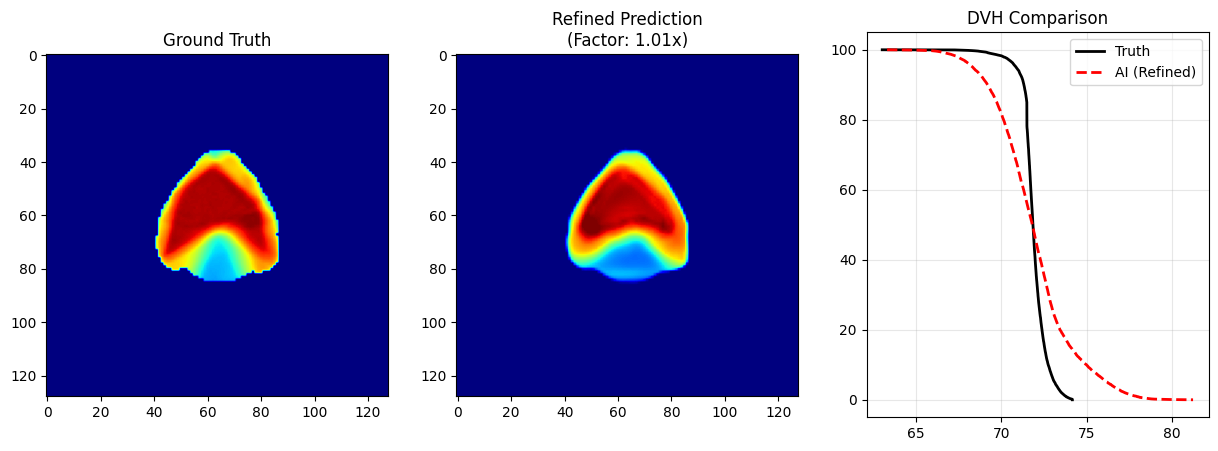

Pt 2: Raw Err=9.3 Gy | Norm Err=4.5 Gy | Factor=1.08x
Pt 3: Raw Err=59.0 Gy | Norm Err=47.5 Gy | Factor=2.00x
Pt 4: Raw Err=2.4 Gy | Norm Err=2.1 Gy | Factor=1.00x


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


Pt 5: Raw Err=8.2 Gy | Norm Err=5.3 Gy | Factor=1.05x
Pt 6: Raw Err=0.0 Gy | Norm Err=2.8 Gy | Factor=0.96x
Pt 7: Raw Err=4.5 Gy | Norm Err=4.5 Gy | Factor=1.00x


C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)
C:\Users\sajid\AppData\Local\Temp\ipykernel_20124\1665503381.py:44: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vals = pd.read_csv(path, header=None)


Pt 8: Raw Err=2.0 Gy | Norm Err=2.5 Gy | Factor=0.99x

🏆 REFINED RESULTS (N=8)
----------------------------------------
Avg MAE:        0.73 Gy
Avg D95 Error:  8.99 Gy
Avg Factor:     1.14x


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os

print(" Validating REFINED Model...")


MODEL_PATH = r"C:\Users\sajid\OneDrive\Desktop\Morpho Dose Project\models\best_model_refined.pth"
DEVICE = "cpu"

model = UNet3D_2Channel().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f" Loaded: {os.path.basename(MODEL_PATH)}")
else:
    print(f" Error: File not found at {MODEL_PATH}")
    
    MODEL_PATH = r"C:\Users\sajid\OneDrive\Desktop\Morpho Dose Project\models\best_model_new.pth"
    if os.path.exists(MODEL_PATH):
        print(f" Falling back to: {os.path.basename(MODEL_PATH)}")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        model.eval()
    else:
        raise StopIteration


def get_dvh_score(dose_vol, mask):
    if mask is None or np.sum(mask) == 0: return np.nan
    voxels = np.sort(dose_vol[mask > 0])
    if len(voxels) == 0: return np.nan
    idx = int(len(voxels) * 0.05)
    return voxels[idx]

def get_dvh_curve(dose_array, mask_array):
    if mask_array is None: return None, None
    voxels = dose_array[mask_array > 0]
    if len(voxels) == 0: return None, None
    voxels = np.sort(voxels)
    y_axis = np.arange(len(voxels), 0, -1) / len(voxels) * 100
    return voxels, y_axis


results_list = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        
        pred = model(inputs)
        
        
        pred_vol = pred.squeeze().cpu().numpy() * 80.0
        true_vol = targets.squeeze().cpu().numpy() * 80.0
        ptv_vol = inputs[0, 1, ...].cpu().numpy()
        
        
        norm_factor = 1.0
        d95_raw = np.nan
        d95_norm = np.nan
        mae_norm = np.nan
        
        if np.sum(ptv_vol) > 0:
            mean_true = np.mean(true_vol[ptv_vol > 0])
            mean_pred = np.mean(pred_vol[ptv_vol > 0])
            norm_factor = mean_true / mean_pred if mean_pred > 0 else 1.0
            
            
            pred_norm = pred_vol * norm_factor
            
            
            d95_t = get_dvh_score(true_vol, ptv_vol)
            d95_p_raw = get_dvh_score(pred_vol, ptv_vol)
            d95_p_norm = get_dvh_score(pred_norm, ptv_vol)
            
            if not np.isnan(d95_t) and not np.isnan(d95_p_raw):
                d95_raw = abs(d95_t - d95_p_raw)
            if not np.isnan(d95_t) and not np.isnan(d95_p_norm):
                d95_norm = abs(d95_t - d95_p_norm)
                
            mae_norm = np.mean(np.abs(true_vol - pred_norm))
            
            print(f"Pt {i+1}: Raw Err={d95_raw:.1f} Gy | Norm Err={d95_norm:.1f} Gy | Factor={norm_factor:.2f}x")
        else:
            print(f"Pt {i+1}:  Empty Mask")

        results_list.append({
            "ID": f"Pt_{i+1}",
            "MAE": mae_norm,
            "D95_Norm": d95_norm,
            "Factor": norm_factor
        })
        
        
        if i == 0 and np.sum(ptv_vol) > 0:
            slice_idx = 64
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            ax[0].imshow(true_vol[:,:,slice_idx], cmap='jet', vmin=0, vmax=75)
            ax[0].set_title("Ground Truth")
            
            ax[1].imshow(pred_norm[:,:,slice_idx], cmap='jet', vmin=0, vmax=75)
            ax[1].set_title(f"Refined Prediction\n(Factor: {norm_factor:.2f}x)")
            
            d_t, v_t = get_dvh_curve(true_vol, ptv_vol)
            d_p, v_p = get_dvh_curve(pred_norm, ptv_vol)
            if d_t is not None:
                ax[2].plot(d_t, v_t, 'k-', linewidth=2, label='Truth')
                ax[2].plot(d_p, v_p, 'r--', linewidth=2, label='AI (Refined)')
                ax[2].legend()
                ax[2].set_title("DVH Comparison")
                ax[2].grid(True, alpha=0.3)
            plt.show()


df = pd.DataFrame(results_list).dropna()
print("\n" + "="*40)
print(f" REFINED RESULTS (N={len(df)})")
print("-" * 40)
if len(df) > 0:
    print(f"Avg MAE:        {df['MAE'].mean():.2f} Gy")
    print(f"Avg D95 Error:  {df['D95_Norm'].mean():.2f} Gy")
    print(f"Avg Factor:     {df['Factor'].mean():.2f}x")
else:
    print(" No valid patients.")
print("="*40)